# Plotting Source Sink Cross Validation Experiment

In [4]:
%load_ext lab_black

In [1]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json
import pickle

from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals
import pingouin as pg

from sklearn.metrics import auc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dabest

# Load Data

In [2]:
root = Path("/Users/adam2392/OneDrive - Johns Hopkins/epilepsy_interictal")
# root = Path("/home/adam2392/hdd/Dropbox/epilepsy_interictal")
deriv_root = root / "derivatives"
source_root = root / "sourcedata"

session = "presurgery"
task = "interictal"
acquisition = "seeg"  # note not all subjects are actually sEEG
reference = "car"
deriv_chain = Path("sourcesink") / reference / "remove_artifact_wins"

deriv_path = deriv_root / deriv_chain

In [3]:
meta_fpath = source_root / "ieeg_database_all.xlsx"

/Users/adam2392/miniforge3/envs/eztrack/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/Users/adam2392/miniforge3/envs/eztrack/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [4]:
subjects = natsorted(get_entity_vals(deriv_path, "subject"))
print(subjects)

['002', '003', '004', '005', '006', '009', '011', '013', '014', '015', 'NIH1', 'NIH2', 'NIH3', 'NIH4', 'NIH5', 'NIH7', 'NIH8', 'NIH9', 'NIH10', 'NIH11', 'PY18N002', 'PY18N013', 'PY18N015', 'PY19N012', 'PY19N015', 'PY19N023', 'PY19N026', 'la01', 'la02', 'la03', 'la04', 'la05', 'la06', 'la07', 'la08', 'la09', 'la10', 'la11', 'la13', 'la15', 'la16', 'la21', 'la22', 'la23', 'la24', 'nl01', 'nl02', 'nl04', 'nl05', 'nl06', 'nl07', 'nl08', 'nl11', 'nl12', 'nl13', 'nl14', 'nl15', 'nl16', 'nl18', 'nl19', 'nl20', 'pt1', 'pt2', 'pt3', 'pt4', 'pt5', 'pt6', 'pt7', 'pt8', 'pt9', 'pt10', 'pt11', 'pt12', 'pt13', 'upmc1', 'upmc2', 'upmc3', 'upmc5', 'upmc6']


## Load Source-Sink Data

In [18]:
n_splits = 10

clf_name = 'sporf'
# n_features = X.shape[1]
n_features = 15
n_estimators = (2000,)
max_features = n_features * 2

# other options:
# source_infl
# sink_ind
# sink_conn
feature_name = "source_infl"

In [19]:
fname = (
    deriv_root
    / f"cv{n_splits}_{clf_name}_mtry{max_features}_exp_allfeats_meandiff.json"
)
print(fname)

/Users/adam2392/OneDrive - Johns Hopkins/epilepsy_interictal/derivatives/cv10_sporf_mtry30_exp_allfeats_meandiff.json


In [20]:
with open(fname.with_suffix(".json"), "r") as fp:
    ss_scores = json.load(fp)

## Load HFO Data

In [12]:
max_features = 10

In [13]:
fname = (
    deriv_root
    / f"cv{n_splits}_{clf_name}_mtry{max_features}_exp_hforates_meandiff.pkl"
)
print(fname)

/Users/adam2392/OneDrive - Johns Hopkins/epilepsy_interictal/derivatives/cv10_sporf_mtry10_exp_hforates_meandiff.pkl


In [14]:
with open(fname.with_suffix(".json"), "r") as fp:
    hfo_scores = json.load(fp)

# Make Plots of the Data

In [72]:
which_set = "test"

tprs = []
aucs = scores[f"{which_set}_roc_auc"]
mean_fpr = np.linspace(0, 1, 100)

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    # interpolate the tpr
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

## Print out Summary Statistics

In [73]:
print(np.mean(aucs), np.std(aucs))

0.8222222222222222 0.09488499851165558


In [74]:
metric = "test_balanced_accuracy"
print(np.mean(scores[metric]), "+/-", np.std(scores[metric]))

0.7621212121212121 +/- 0.06900734801596058


## Making ROC Curve With Confidence Interval

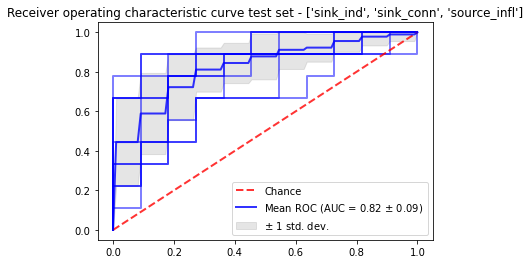

In [75]:
fig, ax = plt.subplots()

for idx in range(n_splits):
    fpr = scores[f"{which_set}_fpr"][idx]
    tpr = scores[f"{which_set}_tpr"][idx]

    ax.plot(fpr, tpr, color="b", lw=2, alpha=0.5)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)


ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title=f"Receiver operating characteristic curve {which_set} set - {feature_set}",
)
ax.legend(loc="lower right")
plt.show()

## Plotting Predicted Probability of Success Scores

In [105]:
y_probas = []
subj_list = []
outcomes = []
centers = []
folds = []

for idx in range(n_splits):
    y_pred_proba = scores[f"{which_set}_y_pred_proba"][idx]
    subjects = scores[f"{which_set}_subjects"][idx]
    for subject in subjects:
        outcome = meta_df[meta_df["patient_id"] == subject]["outcome"].values[0]
        outcomes.append(outcome)

        center = meta_df[meta_df["patient_id"] == subject]["clinical_center"].values[0]
        centers.append(center)

    y_probas.extend(y_pred_proba)
    subj_list.extend(subjects)
    folds.extend([idx] * len(subjects))

In [106]:
proba_df = pd.DataFrame((y_probas, subj_list, outcomes, centers, folds)).T
proba_df.columns = ["y_proba", "subject", "outcome", "center", "fold"]

display(proba_df.head())

,y_proba,subject,outcome,center,fold
0,0.51305,PY19N023,S,jhu,0
1,0.253017,la16,F,cc,0
2,0.202783,015,F,miami,0
3,0.554383,upmc3,F,upmc,0
4,0.38185,la21,S,cc,0


<AxesSubplot:xlabel='outcome', ylabel='y_proba'>

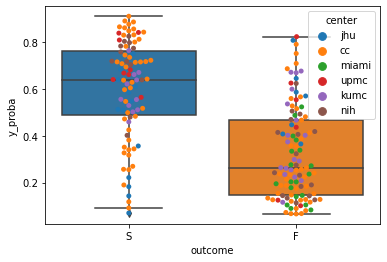

In [103]:
fig, ax = plt.subplots()
# sns.stripplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax)
sns.boxplot(x="outcome", y="y_proba", data=proba_df, ax=ax)
sns.swarmplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax)

<AxesSubplot:xlabel='outcome', ylabel='y_proba'>

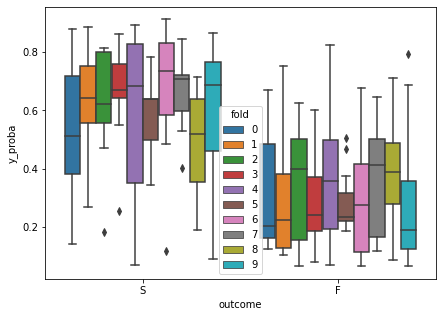

In [110]:
fig, ax = plt.subplots(figsize=(7, 5))
# sns.stripplot(x="outcome", y="y_proba", hue="center", data=proba_df, ax=ax)
sns.boxplot(x="outcome", y="y_proba", hue="fold", data=proba_df, ax=ax)

## Plotting Calibration Curve

In [78]:
mean_brier = np.mean(scores["test_neg_brier_score"])
std_brier = np.std(scores["test_neg_brier_score"])

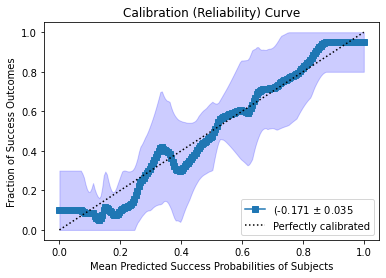

In [82]:
frac_pred_vals = []
mean_pred_values = np.linspace(0, 1.0, 200)

fig, ax = plt.subplots()
color = "blue"
for idx in range(n_splits):
    y_pred_proba = scores[f"{which_set}_y_pred_proba"][idx]

    mean_predicted_value = scores[f"{which_set}_mean_pred_value"][idx]
    fraction_of_positives = scores[f"{which_set}_fraction_pos"][idx]

    # create a linear interpolation of the calibration
    interp_frac_positives = np.interp(
        mean_pred_values, mean_predicted_value, fraction_of_positives
    )

    # store curves
    frac_pred_vals.append(interp_frac_positives)
#     ax.plot(mean_pred_values, interp_frac_positives, "s-", alpha=0.5)

# get the mean calibration curve
mean_frac_pred_values = np.mean(frac_pred_vals, axis=0)
ax.plot(
    mean_pred_values,
    mean_frac_pred_values,
    "s-",
    label=rf"({np.round(mean_brier,3)} $\pm$ {np.round(std_brier, 3)}",
)

# get upper and lower bound for tpr
std_fpv = np.std(frac_pred_vals, axis=0)
tprs_upper = np.minimum(mean_frac_pred_values + std_fpv, 1)
tprs_lower = np.maximum(mean_frac_pred_values - std_fpv, 0)
ax.fill_between(
    mean_pred_values,
    tprs_lower,
    tprs_upper,
    color=color,
    alpha=0.2,
    # label=r"$\pm$ 1 std. dev.",
)
ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")


ax.set(
    ylabel="Fraction of Success Outcomes",
    ylim=[-0.05, 1.05],
    xlabel="Mean Predicted Success Probabilities of Subjects",
    title="Calibration (Reliability) Curve",
)

ax.legend(loc="lower right")
plt.show()